In [ ]:
# Praca analizuje dane giełdowe i próbuje przewidzieć zachowanie akcji.
# Po pierwsze dane są wczytywane z użyciem narzędzia do Pandas, 
# więc pozyskiwanie i czyszczenie danych w zasadzie nie istnieje, 
# bo są one wczytywane jedną komendą i od razu w dobrym stanie. 
# Zatem część inżynierii danych jest nieistniejące. 
# Zostały zastosowanie modele uczenia maszynowego ale wg mnie nie do końca poprawnie, 
# bo w modelach szeregów czasowych przewiduje się kolejny krok a nie całość przebiegu na raz. 
#Ponadto np przy sieciach neuronowych opis mówi, że dodano warstwy Dropout a w kodzie są wyłącznie Dense; 
#zresztą do TS stosuje się RNNy czy LSTMy a nie proste sieci. 
#Dodatkowo, co ważne, nie została użyta żądna technologia BD, co było wymagane; jest tylko Pandas, SKlearn i Keras.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import CSVLogger

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import  train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score

Using TensorFlow backend.
C:\Users\mateu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pyspark

In [3]:
spark = pyspark.sql.SparkSession.builder.appName('x').getOrCreate()

In [4]:
stocks = spark.read.option('inferSchema', 'true').option('header', 'true').csv('all_stocks_5yr.csv')

In [5]:
stocks.take(5)

[Row(date=datetime.datetime(2013, 2, 8, 0, 0), open=15.07, high=15.12, low=14.63, close=14.75, volume=8407500, Name='AAL'),
 Row(date=datetime.datetime(2013, 2, 11, 0, 0), open=14.89, high=15.01, low=14.26, close=14.46, volume=8882000, Name='AAL'),
 Row(date=datetime.datetime(2013, 2, 12, 0, 0), open=14.45, high=14.51, low=14.1, close=14.27, volume=8126000, Name='AAL'),
 Row(date=datetime.datetime(2013, 2, 13, 0, 0), open=14.3, high=14.94, low=14.25, close=14.66, volume=10259500, Name='AAL'),
 Row(date=datetime.datetime(2013, 2, 14, 0, 0), open=14.94, high=14.96, low=13.16, close=13.99, volume=31879900, Name='AAL')]

In [6]:
stock_name = 'GE'
df = pd.read_csv('all_stocks_5yr.csv')
df = df.drop(['volume'], axis=1)
stock_names = df.Name.unique()

In [7]:
df

,date,open,high,low,close,Name
0,2013-02-08,15.07,15.1200,14.6300,14.75,AAL
1,2013-02-11,14.89,15.0100,14.2600,14.46,AAL
2,2013-02-12,14.45,14.5100,14.1000,14.27,AAL
3,2013-02-13,14.30,14.9400,14.2500,14.66,AAL
4,2013-02-14,14.94,14.9600,13.1600,13.99,AAL
5,2013-02-15,13.93,14.6100,13.9300,14.50,AAL
6,2013-02-19,14.33,14.5600,14.0800,14.26,AAL
7,2013-02-20,14.17,14.2600,13.1500,13.33,AAL
8,2013-02-21,13.62,13.9500,12.9000,13.37,AAL
9,2013-02-22,13.57,13.6000,13.2100,13.57,AAL


In [8]:
def extract_stock(stock_name):
    df_stock = df.loc[df['Name'] == stock_name]
    df_stock = df_stock.drop(['Name'], axis=1)
    df_stock = df_stock.dropna()
    df_stock['date'] = pd.to_datetime(df_stock['date'])
    df_stock['close'] = pd.to_numeric(df_stock['close'], downcast='float')
    df_stock.set_index('date',inplace=True)
    df_stock.sort_index(inplace=True)
    
    return df_stock

In [9]:
df_stock = extract_stock('GE')

In [ ]:
############################################################################################
################################### 0. ALL SCRIPTS START ###################################
############################################################################################

In [10]:
df_close = df_stock['close']

In [15]:
df_close.size

1259

In [12]:
df_close = df_close.values.reshape(len(df_close), 1)

In [14]:
df_close.size

1259

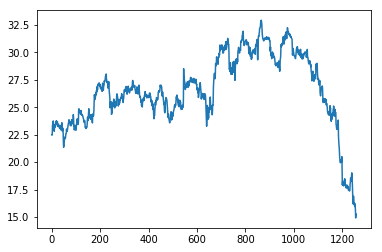

In [16]:
plt.plot(df_close)
plt.show()

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
df_close = scaler.fit_transform(df_close)
df_close

array([[0.42119867],
       [0.41842395],
       [0.42563814],
       ...,
       [0.        ],
       [0.01997781],
       [0.01886791]], dtype=float32)

In [18]:
df_close.size

1259

In [ ]:
train_size = int(len(df_close)*0.8)
test_size = len(df_close) - train_size

df_train, df_test = df_close[0:train_size, :], df_close[train_size:len(df_close), :]

print('Split data into train and test: ', len(df_train), len(df_test))

In [ ]:
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(df_train, series)
testX, testY = create_ts(df_test, series)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
#model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=32)

In [ ]:
#predictions
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)

trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [ ]:
#accuracy
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

In [ ]:
#plot
train_plot = np.empty_like(df_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(df_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(df_close)-1, :] = testPredictions

#plot on graph
plt.plot(scaler.inverse_transform(df_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

In [ ]:
### ANN

#get stock
df_stock = extract_stock(stock_name)

#prepare variables
df_stock['H-L'] = df_stock['high'] - df_stock['low']
df_stock['O-C'] = df_stock['close'] - df_stock['open']
df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
df_stock['Std_dev']= df_stock['close'].rolling(5).std()

#prepare predicted
df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
#remove na after shift
df_stock = df_stock.dropna()
    
#define X
X = df_stock.iloc[:, 4:-1]
    
#define y
y = df_stock.iloc[:, -1]
    
#define split
split_percentage = 0.8
split = int(len(df_stock)*split_percentage)
    
#prepare train and test sets
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
#define scaler
sc = StandardScaler()
    
#scale-replace X_train and X_test
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
    
#define model
classifier = Sequential()
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    
#teach model
csv_logger = CSVLogger('log.csv', append=False, separator=',')
history = classifier.fit(X_train, y_train, batch_size = 10, epochs = 150, verbose = 1, callbacks=[csv_logger], validation_data=(X_test, y_test))

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
    
df_stock['y_pred'] = np.NaN
df_stock.iloc[(len(df_stock) - len(y_pred)):,-1:] = y_pred
df_stock = df_stock.dropna()

#create metric
score = classifier.evaluate(X_test, y_test, verbose=1)

accuracy_train_ANN = history.history['acc'][-1]
accuracy_test_ANN = score[1]

#calculate returns
df_stock['Tomorrows Returns'] = 0.
df_stock['Tomorrows Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
df_stock['Tomorrows Returns'] = df_stock['Tomorrows Returns'].shift(-1)

df_stock['Strategy Returns'] = 0.
df_stock['Strategy Returns'] = np.where(df_stock['y_pred'] == True, df_stock['Tomorrows Returns'], - df_stock['Tomorrows Returns'])

df_stock['Cumulative Market Returns'] = np.cumsum(df_stock['Tomorrows Returns'])
df_stock['Cumulative Strategy Returns'] = np.cumsum(df_stock['Strategy Returns'])

Cumulative_Strategy_Returns = df_stock['Cumulative Strategy Returns']*100
Cumulative_Market_Returns = df_stock['Cumulative Market Returns']

Cumulative_ANN_Returns = Cumulative_Strategy_Returns

#calculate sharpe ratio
Std = Cumulative_Strategy_Returns.std()
Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
Sharpe_ANN = Sharpe.mean()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(Cumulative_Market_Returns, color='r', label='Market Returns')
plt.plot(Cumulative_Strategy_Returns, color='g', label='Strategy Returns')

#plt.plot(Cumulative_KNN_Returns, color='m', label='KNN Returns')
#plt.plot(Cumulative_LR_Returns, color='c', label='LR Returns')
plt.grid()
plt.legend()
plt.show()

In [ ]:
i = 1
for stock_name in stock_names:
    
    print('============= ' + str(i) + ' ===============')
    print('Analysis of ' + stock_name + ' started.')
    
    print('- ANN START -')
    sharpe_ann = ANN2(df, stock_name)
    print('Sharpe ANN ratio: %.2f' %sharpe_ann[0])
    print('- ANN FINISH -')
        
    print('Analysis of ' + stock_name + ' finished.')   
    
    i=i+1


In [ ]:
### compare graphs
stock_picks = top5_ann
for pick in stock_picks:
    df_stock = df.loc[df['Name'] == stock_name]
    df_stock['date'] = pd.to_datetime(df_stock['date'])
    df_stock['close'] = pd.to_numeric(df_stock['close'], downcast='float')
    df_stock.set_index('date',inplace=True)  
    df_stock.sort_index(inplace=True)  
    df_stock.head()
    
    algo = ANN(df, pick)[3]
    market = ANN(df, pick)[4]
    
    plt.figure(figsize=(15,8))
    plt.plot(market, color='r', label='Market Returns')
    plt.plot(algo, color='g', label='ANN Returns')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
df_stock = extract_stock(stock_name)

plt.figure(figsize=(15,8))
#df_stock = df_stock.loc['2017-02-01':'2018-02-01']
plt.plot(df_stock['close'], color='g', label='Close')
plt.grid()
plt.legend()
plt.show()    